# 第8章: 機械学習
本章では，Bo Pang氏とLillian Lee氏が公開しているMovie Review Dataのsentence polarity dataset v1.0を用い，文を肯定的（ポジティブ）もしくは否定的（ネガティブ）に分類するタスク（極性分析）に取り組む．

## 70. データの入手・整形
文に関する極性分析の正解データを用い，以下の要領で正解データ（sentiment.txt）を作成せよ．

1. rt-polarity.posの各行の先頭に"+1 "という文字列を追加する（極性ラベル"+1"とスペースに続けて肯定的な文の内容が続く）
1. rt-polarity.negの各行の先頭に"-1 "という文字列を追加する（極性ラベル"-1"とスペースに続けて否定的な文の内容が続く）
1. 上述1と2の内容を結合（concatenate）し，行をランダムに並び替える

sentiment.txtを作成したら，正例（肯定的な文）の数と負例（否定的な文）の数を確認せよ．

In [1]:
import codecs
import pandas as pd
import numpy as np

def knock_70():
    with codecs.open('../data/rt-polaritydata/rt-polarity.pos', 'r', 'cp1252') as f_pos:
        df_pos = pd.concat([pd.DataFrame([['+1', sentence.rstrip('\n')]]) for sentence in f_pos], ignore_index=True)        
    with codecs.open('../data/rt-polaritydata/rt-polarity.neg', 'r', 'cp1252') as f_neg:
        df_neg = pd.concat([pd.DataFrame([['-1', sentence.rstrip('\n')]]) for sentence in f_neg], ignore_index=True)
    df = pd.concat([df_pos, df_neg], ignore_index=True)
    
    np.random.seed(1)
    df.columns = ['Sentiment', 'Review']
    df = df.reindex(np.random.permutation(df.index))
    df.to_csv('../work/sentiment.txt', sep=' ', index=False)

    print('正例: ' + str((df['Sentiment'] == '+1').sum()) + '件') 
    print('負例: ' + str((df['Sentiment'] == '-1').sum()) + '件')

knock_70()

正例: 5331件
負例: 5331件


In [2]:
!head -n 20 ../work/sentiment.txt

Sentiment Review
-1 "to portray modern women the way director davis has done is just unthinkable . "
-1 "kenneth branagh's energetic sweet-and-sour performance as a curmudgeonly british playwright grounds this overstuffed , erratic dramedy in which he and his improbably forbearing wife contend with craziness and child-rearing in los angeles . "
+1 " . . . with "" the bourne identity "" we return to the more traditional action genre . "
+1 "you can watch , giggle and get an adrenaline boost without feeling like you've completely lowered your entertainment standards . "
+1 "fun , flip and terribly hip bit of cinematic entertainment . "
+1 "fisher has bared his soul and confronted his own shortcomings here in a way . . . that feels very human and very true to life . "
+1 "while the plot follows a predictable connect-the-dots course . . . director john schultz colors the picture in some evocative shades . "
-1 "the impact of the armenian genocide is diluted by too much stage business in th

## 71. ストップワード
英語のストップワードのリスト（ストップリスト）を適当に作成せよ．さらに，引数に与えられた単語（文字列）がストップリストに含まれている場合は真，それ以外は偽を返す関数を実装せよ．さらに，その関数に対するテストを記述せよ．

In [3]:
def is_stop_word(word):
    if not word:
        return True
    if len(word.rstrip()) <= 1:
        return True
    
    STOP_WORD = set("""
    , . a an the at to on of for in by with above under
    this that i you it he she they am are is was were 
    and but though although then as 
    " ' - – ( ) *
    """.lower().split())
    return word.lower() in STOP_WORD

assert is_stop_word('a')
assert is_stop_word('the')
assert is_stop_word('i')
assert is_stop_word('I')
assert is_stop_word('YOU')
assert is_stop_word('"')
assert is_stop_word('*')
assert is_stop_word('')
assert is_stop_word('　')
assert is_stop_word(None)
assert is_stop_word('e')

assert not is_stop_word('good')
assert not is_stop_word('bad')


## 72. 素性抽出
極性分析に有用そうな素性を各自で設計し，学習データから素性を抽出せよ．素性としては，レビューからストップワードを除去し，各単語をステミング処理したものが最低限のベースラインとなるであろう．

In [13]:
import pandas as pd
from stemming.porter2 import stem
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

def stem_tokenizer(sentence):
    return [stem(word) for word in sentence.split(' ') if not is_stop_word(word)]

def extract_feature(text, min_df=1):
    vectorizer = TfidfVectorizer(tokenizer=stem_tokenizer, ngram_range=(1,2), min_df=min_df)
    vectorizer = vectorizer.fit(text)
    vector = vectorizer.transform(text)
    return vectorizer, vector.toarray()

def knock_72():
    df = pd.read_csv('../work/sentiment.txt', sep=' ')
    text = df['Review'].tolist()[:2]
    vectorizer, feature = extract_feature(text)
    print('元文')
    print(text)
    print('\nマッピング')
    print(vectorizer.get_feature_names())
    print('\n素性')
    print(feature)

knock_72()

元文
['to portray modern women the way director davis has done is just unthinkable . ', "kenneth branagh's energetic sweet-and-sour performance as a curmudgeonly british playwright grounds this overstuffed , erratic dramedy in which he and his improbably forbearing wife contend with craziness and child-rearing in los angeles . "]

マッピング
['angel', 'branagh', 'branagh energet', 'british', 'british playwright', 'child-rear', 'child-rear los', 'contend', 'contend crazi', 'crazi', 'crazi child-rear', 'curmudgeon', 'curmudgeon british', 'davi', 'davi has', 'director', 'director davi', 'done', 'done just', 'dramedi', 'dramedi which', 'energet', 'energet sweet-and-sour', 'errat', 'errat dramedi', 'forbear', 'forbear wife', 'ground', 'ground overstuf', 'has', 'has done', 'his', 'his improb', 'improb', 'improb forbear', 'just', 'just unthink', 'kenneth', 'kenneth branagh', 'los', 'los angel', 'modern', 'modern women', 'overstuf', 'overstuf errat', 'perform', 'perform curmudgeon', 'playwright', 'pl

## 73. 学習
72で抽出した素性を用いて，ロジスティック回帰モデルを学習せよ．

In [5]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

def learn_by_logistic_regression(model_output_directory):
    df = pd.read_csv('../work/sentiment.txt', sep=' ')
    X = df['Review'].tolist()
    y = df['Sentiment'].tolist()
    vectorizer, feature = extract_feature(X, min_df=5)
    X_train, X_test, y_train, y_test = train_test_split(feature, y, test_size=0.3, shuffle=False)
    
    lr = LogisticRegression(solver='liblinear', random_state=0)
    model = lr.fit(X_train, y_train)
    print('Accuracy(train): ' + str(lr.score(X_train, y_train)))
    print('Accuracy(test): ' + str(lr.score(X_test, y_test)))
    
    if not os.path.exists(model_output_directory):
        os.makedirs(model_output_directory)
    joblib.dump(model, model_output_directory + '/model.pkl')
    joblib.dump(vectorizer, model_output_directory + '/vectorizer.pkl')

learn_by_logistic_regression('../work/knock_73')

Accuracy(train): 0.881280986199
Accuracy(test): 0.774304470147


## 74. 予測
73で学習したロジスティック回帰モデルを用い，与えられた文の極性ラベル（正例なら"+1"，負例なら"-1"）と，その予測確率を計算するプログラムを実装せよ．

In [6]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

def predict_by_logistic_regression(model_directory, text_array):
    lr = joblib.load(model_directory + '/model.pkl')
    vectorizer = joblib.load(model_directory + '/vectorizer.pkl')
    feature = vectorizer.transform(text_array).toarray()
    predicted_labels = lr.predict(feature)
    predicted_probabilities = lr.predict_proba(feature)
    label_probability_pair = []
    for i, predicted_label in enumerate(predicted_labels):
        if predicted_label == 1:
            label_probability_pair.append(('+1', predicted_probabilities[i][1]))
        else:
            label_probability_pair.append(('-1', predicted_probabilities[i][0]))
    return label_probability_pair

reviews = ['This movie is very funny', 'A story of this movie is excellent', 'This movie is too bad', 'This movie is terrible']
label_probability_pair = predict_by_logistic_regression('../work/knock_73', reviews)
for i, (label, probability) in enumerate(label_probability_pair):
    print(reviews[i] + ' -> ' + label +  ' (' + str(probability) + ')')

This movie is very funny -> +1 (0.737271911721)
A story of this movie is excellent -> +1 (0.594921654769)
This movie is too bad -> -1 (0.950025256101)
This movie is terrible -> -1 (0.769327015675)


## 75. 素性の重み
73で学習したロジスティック回帰モデルの中で，重みの高い素性トップ10と，重みの低い素性トップ10を確認せよ．

In [7]:
import pprint

def knock_75():
    lr = joblib.load('../work/knock_73/model.pkl')
    vectorizer = joblib.load('../work/knock_73/vectorizer.pkl')
    
    feature_names = vectorizer.get_feature_names()
    weights = lr.coef_[0]
    wieght_words_pair = list(zip(weights, feature_names))
    sorted_weight_words_pair = sorted(wieght_words_pair, key=lambda x:x[0], reverse=True)

    print('重みの高い素性トップ10')
    pprint.pprint(sorted_weight_words_pair[:10])
    print('\n重みの低い素性トップ10')
    pprint.pprint(sorted_weight_words_pair[:-11:-1])
    
knock_75()

重みの高い素性トップ10
[(2.8589637435772173, 'beauti'),
 (2.3956275116777275, 'funni'),
 (2.1508983631746128, 'still'),
 (2.10545333197128, 'enjoy'),
 (2.0909607897078031, 'perform'),
 (2.0803539894407517, 'flaw'),
 (2.075159838858827, 'delight'),
 (2.0336450108457118, 'power'),
 (2.0316332176758998, 'fun'),
 (1.9709466052059059, 'wonder')]

重みの低い素性トップ10
[(-3.6672470168602902, 'too'),
 (-3.1052604875431915, 'bad'),
 (-3.0348569442901798, 'dull'),
 (-3.0066066797164042, 'bore'),
 (-2.5026942197892539, 'lack'),
 (-2.3964732569463347, 'no'),
 (-2.1120580536399562, 'onli'),
 (-2.0819031773426446, 'wast'),
 (-2.0143804073628599, 'fail'),
 (-1.9862539662836505, 'worst')]


## 76. ラベル付け
学習データに対してロジスティック回帰モデルを適用し，正解のラベル，予測されたラベル，予測確率をタブ区切り形式で出力せよ．

In [8]:
import pandas as pd

def knock_76():
    df = pd.read_csv('../work/sentiment.txt', sep=' ')
    X = df['Review'].tolist()
    y = df['Sentiment'].tolist()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
    label_probability_pair = predict_by_logistic_regression('../work/knock_73', X_train)
    df = pd.concat([pd.DataFrame(y_train), pd.DataFrame(label_probability_pair)], axis=1)
    df.columns = ['answer', 'predicted', 'pred_prob']
    df['predicted'] = df['predicted'].astype(np.int64)
    df.to_csv('../work/knock_73/result_of_train.tsv', sep='\t', index=False)
    
knock_76()

In [9]:
!head -n 20 ../work/knock_73/result_of_train.tsv

answer	predicted	pred_prob
-1	1	0.6405216335704899
-1	1	0.5336469161529501
1	1	0.684957023248036
1	-1	0.5379757077047782
1	1	0.6998070442209906
1	1	0.7762966417126509
1	-1	0.5032244068733721
-1	-1	0.7804381116937051
1	1	0.847528632471801
1	-1	0.5457859067882957
-1	-1	0.6683289208681973
1	1	0.6103842420868052
-1	-1	0.9169552987061634
1	1	0.868322305211289
-1	-1	0.6917457059983712
-1	-1	0.7182561700192462
1	1	0.6450939087689525
-1	-1	0.523991666110773
-1	-1	0.7461548301598886


## 77. 正解率の計測
76の出力を受け取り，予測の正解率，正例に関する適合率，再現率，F1スコアを求めるプログラムを作成せよ．

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

def knock_77():
    df = pd.read_csv('../work/knock_73/result_of_train.tsv', sep='\t')
    print('precision:\t' + str(precision_score(df['answer'], df['predicted'])))
    print('recall:\t' + str(recall_score(df['answer'], df['predicted'])))
    print('f1:\t' + str(f1_score(df['answer'], df['predicted'])))

knock_77()

precision:	0.884605158203
recall:	0.880391637999
f1:	0.8824933687


## 78. 5分割交差検定
76-77の実験では，学習に用いた事例を評価にも用いたため，正当な評価とは言えない．すなわち，分類器が訓練事例を丸暗記する際の性能を評価しており，モデルの汎化性能を測定していない．そこで，5分割交差検定により，極性分類の正解率，適合率，再現率，F1スコアを求めよ．

In [11]:
import os
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

def knock_78():
    params = {
        'C': [0.1, 1, 10, 100],
        'solver': ['newton-cg', 'liblinear']
    }
    
    df = pd.read_csv('../work/sentiment.txt', sep=' ')
    X = df['Review'].tolist()
    y = df['Sentiment'].tolist()
    vectorizer, feature = extract_feature(X, min_df=5)
    X_train, X_test, y_train, y_test = train_test_split(feature, y, test_size=0.3, shuffle=False)

    lr = LogisticRegression(random_state=0)
    gridsearch_lr = GridSearchCV(lr, param_grid=params, n_jobs=-1, cv=3)
    gridsearch_lr.fit(X_train, y_train)
    print('GridSearch')
    print('Best score:\t' + str(gridsearch_lr.best_score_))
    print('Best parameter:\t' + str(gridsearch_lr.best_params_))
    
    scoring = {
        'a': 'accuracy',
        'p': 'precision',
        'r': 'recall',
        'f': 'f1'
    }
    best_estimator = gridsearch_lr.best_estimator_ 
    kfold = StratifiedKFold(n_splits=5, shuffle=False, random_state=0)
    scores = cross_validate(best_estimator, feature, y, cv=kfold, scoring=scoring)
    print('\n5分割交差検定')
    pprint.pprint(scores)
    print('\nAverage of accuracy:\t{}'.format(np.mean(scores['test_a'])))
    print('Average of precision:\t{}'.format(np.mean(scores['test_p'])))
    print('Average of recall:\t{}'.format(np.mean(scores['test_r'])))
    print('Average of f1:\t{}'.format(np.mean(scores['test_f'])))
    
    model_output_directory = '../work/knock_78'
    if not os.path.exists(model_output_directory):
        os.makedirs(model_output_directory)
    joblib.dump(best_estimator, model_output_directory + '/model.pkl')
    joblib.dump(vectorizer, model_output_directory + '/vectorizer.pkl')

knock_78()

GridSearch
Best score:	0.760016079325
Best parameter:	{'C': 1, 'solver': 'newton-cg'}

5分割交差検定
{'fit_time': array([ 5.02494168,  5.01517606,  5.04694104,  5.0105083 ,  5.08638406]),
 'score_time': array([ 0.05747604,  0.05380106,  0.05505228,  0.05360866,  0.05328178]),
 'test_a': array([ 0.79240862,  0.76829268,  0.75469043,  0.76454034,  0.77861163]),
 'test_f': array([ 0.79133302,  0.76785714,  0.75434476,  0.76476101,  0.77609108]),
 'test_p': array([ 0.79545455,  0.7693032 ,  0.75540922,  0.76404494,  0.78502879]),
 'test_r': array([ 0.78725398,  0.76641651,  0.7532833 ,  0.76547842,  0.7673546 ]),
 'train_a': array([ 0.87664165,  0.87596717,  0.87620164,  0.87713951,  0.87549824]),
 'train_f': array([ 0.87635167,  0.87555869,  0.87541293,  0.87647336,  0.87502942]),
 'train_p': array([ 0.87841659,  0.87845173,  0.88102588,  0.88125148,  0.87833688]),
 'train_r': array([ 0.87429644,  0.87268464,  0.86987104,  0.87174678,  0.87174678])}

Average of accuracy:	0.7717087413466593
Aver

## 79. 適合率-再現率グラフの描画
ロジスティック回帰モデルの分類の閾値を変化させることで，適合率-再現率グラフを描画せよ．

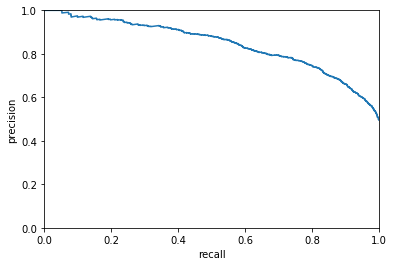

In [12]:
import pandas as pd
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def knock_79():
    df = pd.read_csv('../work/sentiment.txt', sep=' ')
    X = df['Review'].tolist()
    y = df['Sentiment'].tolist()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
    
    lr = joblib.load('../work/knock_78/model.pkl')
    vectorizer = joblib.load('../work/knock_78/vectorizer.pkl')
    feature = vectorizer.transform(X_test).toarray()
    predicted_probabilities = lr.predict_proba(feature)
    precision, recall, thresholds = precision_recall_curve(y_test, predicted_probabilities[:,1])
    
    plt.plot(recall, precision)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()
    
knock_79()